In [5]:
from pytorch_lightning import (
    Callback,
    LightningDataModule,
    LightningModule,
    Trainer,
    seed_everything,
)
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchmetrics.regression import CosineSimilarity
import torchxrayvision as xrv 
import os, sys
sys.path.append("..")

#from src import utils
import pandas as pd
import wandb
import skimage, skimage.filters
import sklearn, sklearn.metrics


from utils import generate_explanation,generate_vector,generate_vector_cav,calc_iou

os.environ['WANDB_NOTEBOOK_NAME'] = "gifsplanation_playground.ipynb"


In [8]:
from typing import List
from kmeans_pytorch import kmeans
from einops import rearrange

class ClusteredVectorFinder:
    def __init__(self,num_clusters: int, vectors: torch.tensor, distance='cosine') -> None:
        vectors = rearrange(vectors, "num a b c d -> num (a b c d)")
        self.num_clusters = num_clusters
        self.distance = distance
        self.cluster_ids_x, self.cluster_centers = kmeans(
            X=vectors, num_clusters=num_clusters, distance=distance, device=torch.device('cuda:0')
        )


    def find_closest(self,vector):
        dist = torch.cosine_similarity(self.cluster_centers,vector.to("cpu").reshape(1,-1))
        min_index = torch.argmin(dist)
        return self.cluster_centers[min_index].to("cuda").view_as(vector)

In [6]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic")
clf = xrv.models.DenseNet(weights="all")
ae = ae.cuda()
clf = clf.cuda()


In [7]:
from torchsampler import ImbalancedDatasetSampler
from torchvision.transforms import Compose
from torchxrayvision.datasets import XRayCenterCrop, XRayResizer, normalize, apply_transforms, relabel_dataset, SubsetDataset
from datawrappers import NIH_wrapper, CheX_wrapper, VINBig_wrapper

transforms = Compose([XRayCenterCrop(),XRayResizer(224)])
nih_ds = NIH_wrapper(r"/mnt/mp1/@ais/nih_raw/%ob/",\
    csvpath=r"/mnt/mp1/@ais/nih_raw/%ob/Data_Entry_2017_v2020.csv",\
    bbox_list_path=r"/mnt/mp1/@ais/nih_raw/%ob/BBox_List_2017.csv",\
    unique_patients=True,
    transform=transforms)
relabel_dataset(clf.pathologies,nih_ds,silent=False)

#chex_ds = CheX_wrapper(r"/mnt/mp1/@ais/chexpert_raw/%ob",r"/mnt/mp1/@ais/chexpert_raw/%ob/train.csv",transform=transforms)
#relabel_dataset(clf.pathologies,chex_ds,silent=False)
#chex_ds.labels = np.nan_to_num(chex_ds.labels,0)
#Chexpert_datamodule = torch.utils.data.DataLoader(chex_ds,batch_size=500,pin_memory=False)

vbg_ds = VINBig_wrapper(r"/mnt/mp1/@ais/vinbig/%ob/train",r"/mnt/mp1/@ais/vinbig/%ob/train.csv",transform=transforms)
relabel_dataset(clf.pathologies,vbg_ds,silent=False)
vbg_ds.labels = np.nan_to_num(vbg_ds.labels,0)


Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.
{'Lesion', 'ILD', 'Nodule/Mass', 'Calcification', 'Aortic enlargement', 'Pulmonary Fibrosis'} will be dropped
Edema doesn't exist. Adding nans instead.
Emphysema doesn't exist. Adding nans instead.
Fibrosis doesn't exist. Adding nans instead.
Pneumonia doesn't exist. Adding nans instead.
Nodule doesn't exist. Adding nans instead.
Mass doesn't exist. Adding nans instead.
Hernia doesn't exist. Adding nans instead.
Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.


In [8]:
NIH_ds = NIH_wrapper(r"/mnt/mp1/@ais/nih_bbox/%ob/",\
    csvpath=r"/mnt/mp1/@ais/nih_bbox/%ob/Data_Entry_2017_v2020.csv",\
    bbox_list_path=r"/mnt/mp1/@ais/nih_bbox/%ob/BBox_List_2017.csv",\
    unique_patients=True,
    transform=transforms,
    pathology_masks=True)
NIH_ds = SubsetDataset(NIH_ds, NIH_ds.csv[NIH_ds.csv["has_masks"]].index)
relabel_dataset(clf.pathologies,NIH_ds,silent=False)
NIH_datamodule = torch.utils.data.DataLoader(NIH_ds,batch_size=500,pin_memory=False)


Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.


In [9]:
len(NIH_ds)

125

In [41]:
def eval(ae, generate_vector, target, data,method=None):
    if method:   
        wandb.init(project="concept_vector_stability",name=str(method)+" "+target)
    else:
        wandb.init(project="concept_vector_stability")
    result = []
    per_sample_table = None
    for sample in data:
        if sample["label"][data.dataset.pathologies.index(target)] == 1: 
            if target not in sample["pathology_masks"]:
                #print("no mask found")
                continue
            image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()
            vector = generate_vector(image,target)
            dimage,_ = generate_explanation(sample, vector, target, ae=ae, clf=clf)
            metrics = calc_iou(dimage, sample["pathology_masks"][target]['mask'])
            recon = ae(image)["out"]
            metrics["mse"] = float(((image-recon)**2).mean().detach().cpu().numpy())
            metrics["mae"] = float(torch.abs(image-recon).mean().detach().cpu().numpy())
            metrics["idx"] = sample["idx"]
            metrics["method"] = method
            #metrics["p"] = float(p)
            #metrics["target"] = target
            if per_sample_table: 
                per_sample_table.add_data(*list(metrics.values()))
            else: 
                per_sample_table = wandb.Table(dataframe=pd.DataFrame(metrics,index=[metrics['idx']]))
            result.append(metrics)
            image = wandb.Image(image, caption="original image", masks= {"predictions":{"mask_data":sample["pathology_masks"][target]["mask"][0]}})
            r_image = wandb.Image(recon,caption="reconstruction")
            mask = wandb.Image(sample["pathology_masks"][target]["mask"][0],caption="gt mask")
            fig = plt.imshow(dimage)
            wandb.log({"mask":mask,"salincy": fig,"original":image,"reconstruction":r_image,"target":target,"vector":vector})
    wandb.log({"res_table":per_sample_table,"total_table":pd.DataFrame(result).groupby("method").agg("mean")})
    return pd.DataFrame(result)

In [44]:
for_eval = [
          # "Cardiomegaly",
            'Mass',
            'Nodule', 
           "Atelectasis",
            "Effusion",
          #  "Lung Opacity",
            ]

Starting exp for Mass


target,Cardiomegaly


Starting exp for Nodule


target,Mass


Starting exp for Atelectasis


target,Nodule


Starting exp for Effusion


target,Atelectasis


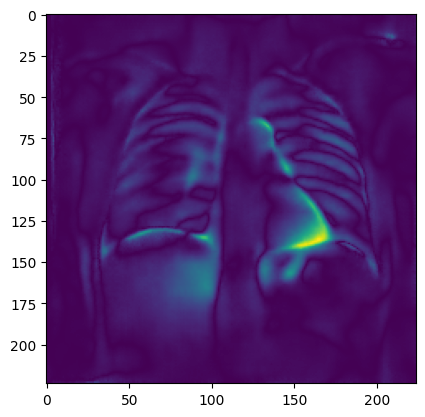

In [45]:
for target in for_eval:
    print(f"Starting exp for {target}")
    #def calculate_perceptual_clusters(dataloader,target):
    #    vectors = []
    #    samples = []
    #    for sample in dataloader:
    #        if sample["label"][clf.pathologies.index(target)] == 1: 
    #            image = torch.tensor(sample['img']).clone().unsqueeze(0)
    #            image.requires_grad = True
    #            image_shape = image.shape
    #            image = image.to("cuda")
    #            vectors.append(generate_vector(image,target,ae=ae,clf=clf).to("cpu"))
    #            samples.append(sample)
    #    vectors = torch.stack(vectors)
    #    return vectors 
    #vectors_chex = calculate_perceptual_clusters(chex_ds,target)
    #vectors_nih = calculate_perceptual_clusters(nih_ds,target)
    #vectors_vbg = calculate_perceptual_clusters(vbg_ds,target)
    #print(f"Getting CAVs {target}")

    #chexpert_train_cavs = get_cavs(chex_ds,target)
    nih_train_cavs = get_cavs(nih_ds,target)
    #vbg_train_cavs = get_cavs(vbg_ds,target)

    #centroiders_nih = {10: ClusteredVectorFinder(10,vectors_nih), 20: ClusteredVectorFinder(20,vectors_nih), 
    #50: ClusteredVectorFinder(50,vectors_nih),
    #100: ClusteredVectorFinder(100,vectors_nih)}

    #centroiders_chex = {10: ClusteredVectorFinder(10,vectors_chex), 20: ClusteredVectorFinder(20,vectors_chex), 
    #50: ClusteredVectorFinder(50,vectors_chex),
    #100: ClusteredVectorFinder(100,vectors_chex)}


    #centroiders_vbg = {10: ClusteredVectorFinder(10,vectors_vbg), 20: ClusteredVectorFinder(20,vectors_vbg), 
    #50: ClusteredVectorFinder(50,vectors_vbg),
    #100: ClusteredVectorFinder(100,vectors_vbg)}

    experiments = [
        #{"method": "nih_cav_1 max", "function":lambda x,y : generate_vector_cav(nih_train_cavs,1,)},
        #{"method": "nih_cav_2 max", "function":lambda x,y : generate_vector_cav(nih_train_cavs,2)},
        #{"method": "nih_cav_mean max", "function":lambda x,y : generate_vector_cav(nih_train_cavs,1,mean=True)},
        #{"method": "chex_cav_1 max", "function":lambda x,y : generate_vector_cav(chexpert_train_cavs,1)},
        #{"method": "chex_cav_2 max", "function":lambda x,y : generate_vector_cav(chexpert_train_cavs,2)},
        #{"method": "chex_cav_mean max", "function":lambda x,y : generate_vector_cav(chexpert_train_cavs,1,mean=True)},
        {"method": "latentshift max", "function": lambda x,y : generate_vector(x,y,ae=ae,clf=clf)},
        #{"method": "vbg_cav_1 max", "function":lambda x,y : generate_vector_cav(vbg_train_cavs,1,)},
        #{"method": "vbg_cav_2 max", "function":lambda x,y : generate_vector_cav(vbg_train_cavs,2)},
        #{"method": "vbg_cav_mean max", "function":lambda x,y : generate_vector_cav(vbg_train_cavs,1,mean=True)},

        #{"method": "centroid 10 all", "function": lambda x,y: centroiders_nih[10].find_closest(generate_vector(x,y,ae=ae,clf=clf))},
        #{"method": "centroid 20 all", "function": lambda x,y: centroiders_nih[20].find_closest(generate_vector(x,y,ae=ae,clf=clf))},
        #{"method": "centroid 50 all", "function": lambda x,y: centroiders_nih[50].find_closest(generate_vector(x,y,ae=ae,clf=clf))},
        #{"method": "centroid 100 all", "function": lambda x,y: centroiders_nih[100].find_closest(generate_vector(x,y,ae=ae,clf=clf))}]

        #{"method": "centroid 10 all", "function": lambda x,y: centroiders_chex[10].find_closest(generate_vector(x,y,ae=ae,clf=clf))},
        #{"method": "centroid 20 all", "function": lambda x,y: centroiders_chex[20].find_closest(generate_vector(x,y,ae=ae,clf=clf))},
        #{"method": "centroid 50 all", "function": lambda x,y: centroiders_chex[50].find_closest(generate_vector(x,y,ae=ae,clf=clf))},
        #{"method": "centroid 100 all", "function": lambda x,y: centroiders_chex[100].find_closest(generate_vector(x,y,ae=ae,clf=clf))}
    ]
    for cfg in experiments:
        res = eval(ae,cfg['function'],target,NIH_ds,method=cfg['method'])

In [34]:
NIH_ds[1]

{'idx': 792,
 'img': array([[[ -821.988  ,  -917.89856,  -917.963  , ...,  -917.963  ,
           -917.90234,  -822.9063 ],
         [ -917.2868 , -1023.86206, -1023.93225, ..., -1023.93225,
          -1023.86456,  -917.9023 ],
         [ -917.9344 , -1023.9322 , -1024.     , ..., -1024.     ,
          -1023.93225,  -917.963  ],
         ...,
         [  731.53595,   807.7178 ,   817.28375, ...,   283.59457,
            228.79352,   157.89124],
         [  807.0417 ,   902.5005 ,   903.6734 , ...,   580.5132 ,
            532.8999 ,   416.05283],
         [  738.7174 ,   828.5208 ,   829.9479 , ...,   739.4656 ,
            712.3965 ,   584.02356]]], dtype=float32),
 'label': array([1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       dtype=float32),
 'pathology_masks': {'Atelectasis': {'mask': array([[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
 

wandb: wandb version 0.13.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


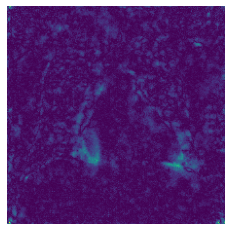

In [31]:
wandb.init("hui")
fig = plt.imshow(dimage2)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
wandb.log({"salincy": fig})